<a href="https://colab.research.google.com/github/bassoline/DeepLearning/blob/main/ClassificationMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline 
import numpy as np 
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
import warnings 
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8,8)

Input (X) shape: (100, 2)
Labels (Y) shape: (100,)


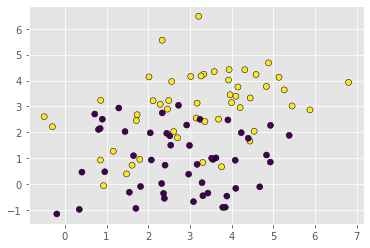

In [14]:
# generate dataset 
seed = 42 
randomGenerator = np.random.RandomState(seed)
torch.manual_seed(seed)

# generate two class classification data 
X, Y = make_classification(
    n_features = 2, 
    n_redundant = 0, 
    n_informative = 2, 
    random_state = seed, 
    n_clusters_per_class = 1
)

# add some noise 
X += 4 * randomGenerator.uniform(size = X.shape)

print('Input (X) shape: {}'.format(X.shape))
print('Labels (Y) shape: {}'.format(Y.shape))

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k')

# divide data into test and training data 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = seed)
# convert from numpy to torch 
x_train, y_train = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float().reshape(-1,1)
x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float().reshape(-1,1)

In [3]:
class LogisticRegression(nn.Module): 
  def __init__(self, n_features):
    super().__init__()
    # linear layer (WX+B)
    self.linear = nn.Linear(n_features, 1, bias=True)
  
  def forward(self, x): 
    # calculate WX + B 
    x = self.linear(x)
    # sigmoid activation for prediction
    predictions = torch.sigmoid(x)
    return predictions

In [4]:
class Trainer: 
  def __init__(self, model, criterion, optimizer, epoch_num): 
    self.model = model
    # fancy way to say loss function
    self.criterion = criterion 
    self.optimizer = optimizer 
    self.epoch_num = epoch_num

  def fit(self, inputs, targets): 
    # set model in train state 
    self.model.train()
    
    for _ in range(self.epoch_num): 
      # set gradient to zero
      self.optimizer.zero_grad()
      # forward pass w/ predictions
      preds = self.model(inputs)
      # get the loss 
      loss = self.criterion(preds, targets)
      # calculate gradients
      loss.backward()
      # update params 
      self.optimizer.step()
  
  def predict(self, inputs): 
    # set model in evaluation state 
    self.model.eval()
    # turn off code for backprop
    with torch.no_grad(): 
      preds = self.model(inputs)
      
    return preds


In [15]:
# initalize model, optimizer, loss function
epoch_num = 200
learning_rate = 0.01
log_regression = LogisticRegression(n_features=2)
# binary cross entropy loss 
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(log_regression.parameters(), lr=learning_rate)
trainer = Trainer(log_regression, criterion, optimizer, epoch_num)

# train the model 
trainer.fit(x_train, y_train)

# predict with the model 
y_predicted = trainer.predict(x_test)

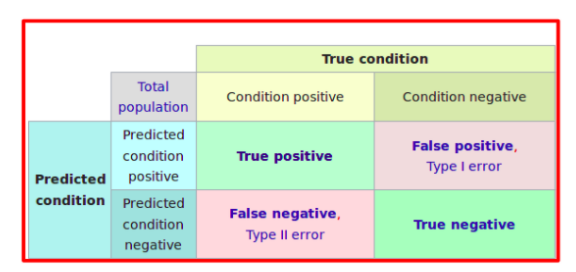

In [6]:
# confusion matrix is based on the above matrix 
class ConfusionMatrix: 
  def __init__(self): 
    # init confusion matrix 
    self.conf = np.ndarray((2, 2), np.int32)
  
  def reset(self): 
    self.conf.fill(0)

  # take predicition and Truth value, compute confusion matrix
  def add(self, pred, target): 
    # taking target [0, 1, 0, 1] and pred [1, 1, 0, 1] -> [[0, 1], ...]
    replace_indicies = np.vstack((target.flatten(), pred.flatten())).T
    # convert to 2 x 2 bins to create confusion matrix
    conf, _ = np.histogramdd(replace_indicies, bins=(2, 2), range=[(0, 2), (0, 2)])
    self.conf += conf.astype(np.int32)
  
  def TP(self): 
    return self.conf[1, 1]
  
  def FP(self): 
    return self.conf[0, 1]
  
  def TN(self):
    return self.conf[0, 0]
  
  def FN(self): 
    return self.conf[1, 0]
  
  def get_matrix(self): 
    cm = np.array([[self.TP(), self.FP()], [self.FN(), self.TN()]])
    return cm

In [7]:
# verify output of confusion matrix 
cm = ConfusionMatrix()
cm.reset()

threshold = 0.5 
predictions = y_predicted > threshold

cm.add(predictions, y_test)
print('Confusion Matrix for threshold probability 0.5 :\n{}'.format(cm.get_matrix()))

cm.reset()
threshold = 0.6 
predictions = y_predicted > threshold
cm.add(predictions, y_test)
print('Confusion Matrix for threshold probability 0.6 :\n{}'.format(cm.get_matrix()))

cm.reset()
threshold = 0.7
predictions = y_predicted > threshold
cm.add(predictions, y_test)
print('Confusion Matrix for threshold probability 0.7 :\n{}'.format(cm.get_matrix()))

Confusion Matrix for threshold probability 0.5 :
[[8 6]
 [3 8]]
Confusion Matrix for threshold probability 0.6 :
[[ 7  4]
 [ 4 10]]
Confusion Matrix for threshold probability 0.7 :
[[ 4  2]
 [ 7 12]]


In [8]:
def accuracy(confusion_matrix):
  return (confusion_matrix.TP() + confusion_matrix.TN()) / sum(sum(confusion_matrix.get_matrix()))

def percision(confusion_matrix):
  return confusion_matrix.TP() / (confusion_matrix.TP() + confusion_matrix.FP())

def recall(confusion_matrix): 
  return confusion_matrix.TP() / (confusion_matrix.TP() + confusion_matrix.FN())

def f1_score(confusion_matrix): 
  return 2 * confusion_matrix.TP() / (2 * confusion_matrix.TP() + confusion_matrix.FP() + confusion_matrix.FN())


In [9]:
acc = accuracy(cm)
percision_ = percision(cm)
recall_ = recall(cm)
f1_score_ = f1_score(cm)

print('Accuracy at {} threshold: {}'.format(threshold, acc))
print('Percision at {0:0.3} threshold: {0:.3}'.format(threshold, percision_))
print('Recall at {0:0.3} threshold: {0:.3}'.format(threshold, recall_))
print('F1 score at {0:0.3} threshold: {0:.3}'.format(threshold, f1_score_))

Accuracy at 0.7 threshold: 0.64
Percision at 0.7 threshold: 0.7
Recall at 0.7 threshold: 0.7
F1 score at 0.7 threshold: 0.7


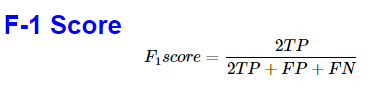

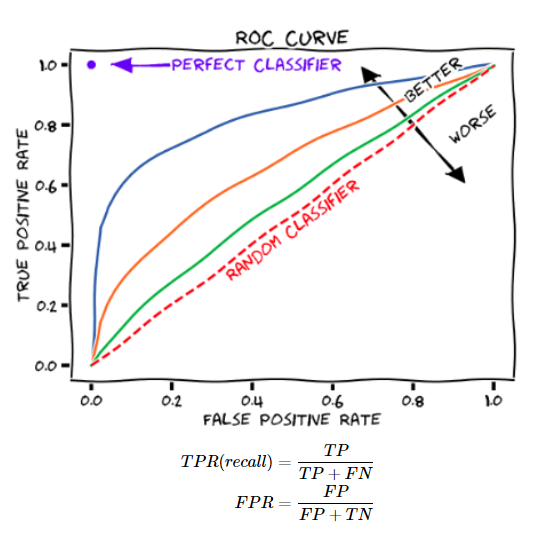



In [17]:
thresholds = np.linspace(0.001, 0.999, 1000)

tp_rates = []
fp_rates = []
cm = ConfusionMatrix()

for threshold in thresholds:

    # get prediction
    predictions = y_predicted > threshold
    
    # rest confusion matrix
    cm.reset()
    
    # calculate confusion matrix
    cm.add(predictions, y_test)
    
    # get TP, FP, FN, and TN to calculate TPR and FPR
    TN = cm.TN()
    FP = cm.FP()
    FN = cm.FN()
    TP = cm.TP()

    # Sensitivity, recall, or true positive rate
    TPR = TP / (TP + FN)
    tp_rates.append(TPR)

    # False positive rate
    FPR = FP / (FP + TN)
    fp_rates.append(FPR)

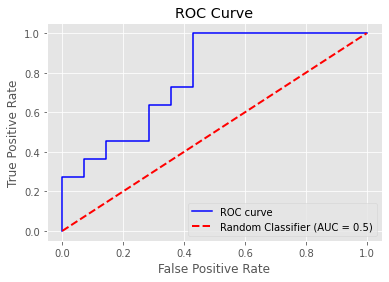

In [18]:
plt.plot(fp_rates, tp_rates, label='ROC curve', color='b')
plt.plot([0, 1], [0, 1], label='Random Classifier (AUC = 0.5)', linestyle='--', lw=2, color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()